# Łańcuch Markowa

## Schemat uczenia modelu

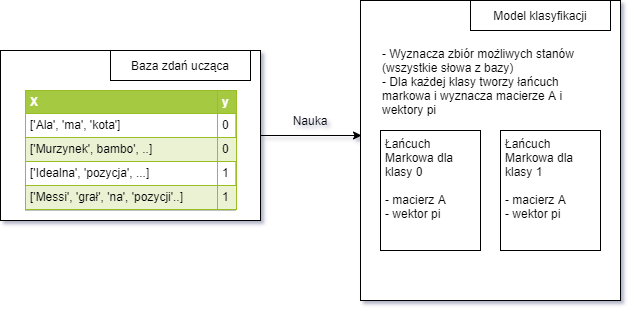

## Schemat predykcji

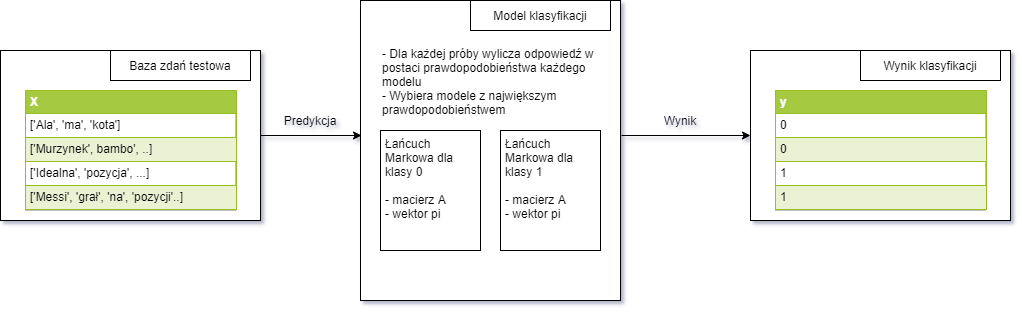


## Przygotowanie bazy

In [31]:
import numpy as np
from sklearn.model_selection import train_test_split

flatten = lambda t: [item for sublist in t for item in sublist]

def preprocess_data(path, label):
    f = open(path, encoding="utf8")
    expose = ''.join(f.readlines())

    chars_to_remove = ['+', ',', '-', ':', ';', '?', '–', '”', '„', '…', '\n', '\n\n', '  ', '%', '(', ')', '\xad', '/']
    for char in chars_to_remove: 
        expose = expose.replace(char, ' ')
    expose = expose.lower()

    sentences = expose.split('. ')
    words_in_sentences = np.array([sentence.split() for sentence in sentences], dtype=object)
    
    X = np.reshape(words_in_sentences, (-1, 1))
    y = np.ones(X.shape) * label
    data = np.hstack((X, y))
    
    return X, y

In [32]:
X_tusk, y_tusk = preprocess_data('data/tusk2011.txt', 1)
X_szydlo, y_szydlo = preprocess_data('data/szydlo2015.txt', 2)
X_morawiecki, y_morawiecki = preprocess_data('data/morawiecki2019.txt', 3)
X_kopacz, y_kopacz = preprocess_data('data/kopacz2014.txt', 4)

In [33]:
X = np.vstack((X_tusk, X_szydlo, X_morawiecki, X_kopacz))
y = np.vstack((y_tusk, y_szydlo, y_morawiecki, y_kopacz))

## Klasyfikator

In [61]:
class MarkovChain:
    def __init__(self, X, states):
        self.A = np.zeros((len(states), len(states)))
        self.pi = np.zeros(len(states))
        self.states = states
        print(f"MarkovChain created from {X.shape}")
        
        for sentence in X:
            if sentence == []:
                continue
            index_first_word = states.index(sentence[0])
            self.pi[index_first_word] += 1
            for i in range(1, len(sentence)):
                prev_state = states.index(sentence[i-1])
                curr_state = states.index(sentence[i])
                self.A[prev_state, curr_state] += 1
        self.pi = self.pi/np.sum(self.pi)
        self.A = self.A/np.sum(self.A, axis=1, keepdims=True)
        self.A[self.A<1e-4] = 1e-4
        self.pi[self.pi<1e-4] = 1e-4
        
    def predict_proba(self, X):
        probas = []
        for index in range(X.shape[0]):
            sentence = X[index, 0]
            if sentence == []:
                continue
            proba = 0
            index_first_word = self.states.index(sentence[0])
            first_char_proba = np.log(self.pi[index_first_word])
            if first_char_proba != 0:
                proba = proba + first_char_proba
            
            for i in range(1, len(sentence)):
                prev_state = self.states.index(sentence[i-1])
                curr_state = self.states.index(sentence[i])
                transition_proba = self.A[prev_state, curr_state]
                if transition_proba != 0:
                    proba = proba + np.log(transition_proba)
            probas.append(proba)
        return np.sum(probas)

In [62]:
class MarkovClassifier:
    def __init__(self):
        self.markov_chains = {}
        self.states = None
        self.labels = None
        
    def fit(self, X, y):
        # prepare states
        words = flatten(flatten(X))
        self.states = np.unique(words).tolist()
        
        # prepare models
        self.labels = np.unique(y)
        for label in self.labels:
            self.markov_chains[label] = MarkovChain(X[y == label], self.states)
        
        print(self.markov_chains)
    
    def predict(self, X):
        probas = {}
        for label in self.labels:
            probas[label] = self.markov_chains[label].predict_proba(X)
        return probas

In [63]:
mc = MarkovClassifier()
mc.fit(X, y)

MarkovChain created from (273,)


c:\dev\data_mining\.venv\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


MarkovChain created from (460,)
MarkovChain created from (589,)
MarkovChain created from (300,)
{1.0: <__main__.MarkovChain object at 0x000002D1D5DCFB88>, 2.0: <__main__.MarkovChain object at 0x000002D1D5D5CA48>, 3.0: <__main__.MarkovChain object at 0x000002D1D5DCFCC8>, 4.0: <__main__.MarkovChain object at 0x000002D1D5DCFE08>}


In [64]:
mc.predict(X_szydlo)

{1.0: nan, 2.0: -10648.62517356186, 3.0: nan, 4.0: nan}